https://www.kaggle.com/code/aravindanr22052001/understanding-pytorch-transforms

https://pytorch.org/vision/0.9/transforms.html

- primeiro treino: 50 épocas
  * sem transformação: acc: 0,85, precision: 0,85, recall: 0,85
  * rotação: acc: 0,84, precision: 0,85, recall: 0,84
  * flip horizontal: acc: 0,69, precision: 0,72, recall: 0,69
  * resize: acc: 0,86, precision: 0,85, recall: 0,86
  * crop: acc: 0,86, precision: 0,86, recall: 0,86
  * normalização: acc: 0,86, precision: 0,85, recall: 0,86

================================================================================
- segundo treino: 100 épocas
  * sem transformação: acc: 0,86, precision: 0,85, recall: 0,86
  * rotação: acc: 0,85, precision: 0,86, recall: 0,85
  * flip horizontal: acc: 0,83, precision: 0,83, recall: 0,83
  * resize: acc: 0,86, precision: 0,85, recall: 0,86
  * crop: acc: 0,86, precision: 0,86, recall: 0,86
  * normalização: acc: 0,86, precision: 0,85, recall: 0,86

===============================================================================
- terceiro treino: adição da visualização das imagens em cada transformação feita; junção do rotation, resize e normalização, 50 épocas e p=0.25 no flip horizontal
  * sem transformação: acc: 0,85, precision: 0,86, recall: 0,85
  * rotação: acc: 0,84, precision: 0,84, recall: 0,84
  * flip horizontal: acc: 0,64, precision: 0,69, recall: 0,64
  * resize: acc: 0,86, precision: 0,86, recall: 0,86
  * crop: acc: 0,86, precision: 0,85, recall: 0,86
  * normalização: acc: 0,86, precision: 0,86, recall: 0,86
  * all: acc: 0,81, precision: 0,82, recall: 0,81

================================================================================
- quarto treino: inserção de outras transformações - gaussian blur, pad e gray scale
-> mudança em relação as slices que estão sendo usadas, ao perceber que estavam tendo as slices referentes as mesmas pessoas e por isso, a acurácia estava dando tão alta
-> modificação do dataset, pegando somente a slice 01 de cada indíviduo em todos os grupos, isso nos faz ter menos amostras

treino com 50 épocas, a acc e recall deram 0.3 e a precision deu 0.40
treino com 100 épocas: crop, normalize e pad é o que ajudam






# Imports

In [1]:
# Checa ambiente - se rodando local não usa o Google Drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if (IN_COLAB):
    !pip install pytorch_lightning -qqq
    import pytorch_lightning
    !pip install neptune
    import neptune
    from google.colab import drive
    drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━

In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [4]:
# Redução das mensagens de log no terminal.
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados

In [17]:
if (IN_COLAB):
    root = '/content/gdrive/MyDrive/IA901A_Projeto/data/interim/OASIS_slices2_flat_single/OASIS_slices2_flat_single_3classes'
else:
    root = 'OASIS_slices2_flat_single_3classes/'

transform_base = transforms.Compose([
    transforms.ToTensor()
    ])
transform_rotate = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])
transform_hzflip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.ToTensor()
    ])
transform_resize = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
    ])
transform_crop = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])
transform_all = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Pad((3,3),padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])
transform_gaussian = transforms.Compose([
    transforms.GaussianBlur((7,7)),
    transforms.ToTensor()
    ])
transform_pad = transforms.Compose([
    transforms.Pad((3,3),padding_mode='reflect'),
    transforms.ToTensor()
    ])
#transform_erase = transforms.Compose([
#    transforms.RandomErasing(0.5),
#    transforms.ToTensor()
#    ])
transform_gray = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor()
    ])

In [18]:
dataset0=datasets.ImageFolder(root=root,transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

118
['MildDemented', 'NonDemented', 'VeryMildDemented']
3


In [19]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform, batch_size=32):
        super().__init__()
        self.root_dir = root
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=3)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [20]:
# Datamodules baseados nas transformações

datamodule_base = DataModule(transform_base)
datamodule_base.setup()

datamodule_rotate = DataModule(transform_rotate)
datamodule_rotate.setup()

datamodule_hzflip = DataModule(transform_hzflip)
datamodule_hzflip.setup()

datamodule_resize = DataModule(transform_resize)
datamodule_resize.setup()

datamodule_crop = DataModule(transform_crop)
datamodule_crop.setup()

datamodule_normalize = DataModule(transform_normalize)
datamodule_normalize.setup()

datamodule_all = DataModule(transform_all)
datamodule_all.setup()

datamodule_gaussian = DataModule(transform_gaussian)
datamodule_gaussian.setup()

datamodule_pad = DataModule(transform_pad)
datamodule_pad.setup()

#datamodule_erase = DataModule(transform_erase)
#datamodule_erase.setup()

datamodule_gray = DataModule(transform_gray)
datamodule_gray.setup()

# Vizualizando imagens

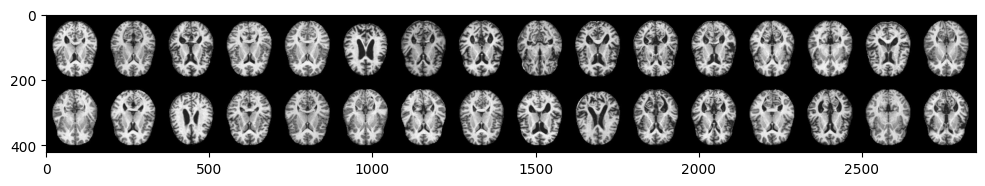

In [ ]:
for images, labels in datamodule_base.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

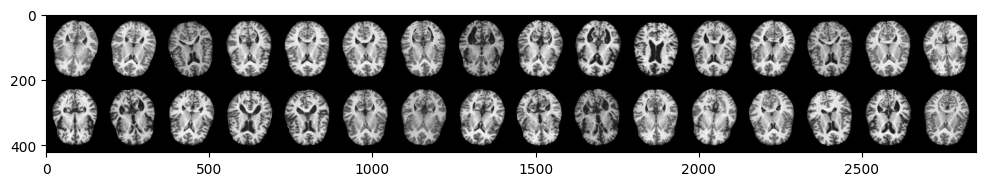

In [ ]:
for images, labels in datamodule_rotate.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

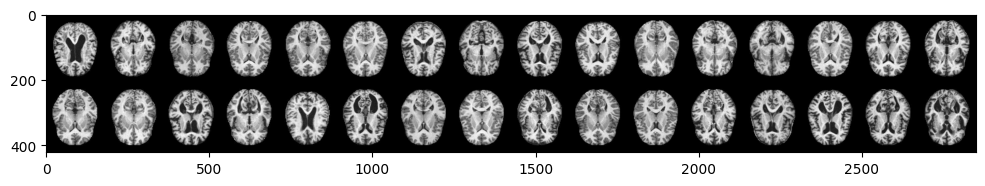

In [ ]:
for images, labels in datamodule_hzflip.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

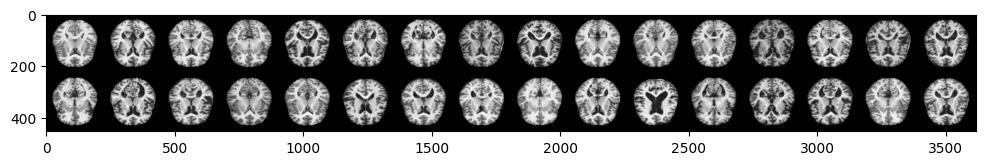

In [ ]:
for images, labels in datamodule_resize.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

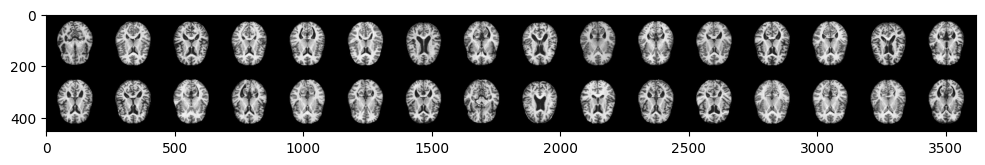

In [ ]:
for images, labels in datamodule_crop.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

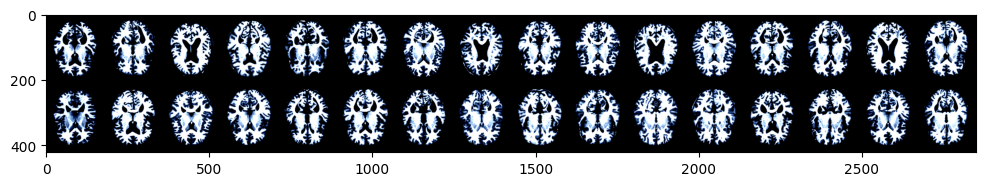

In [ ]:
for images, labels in datamodule_normalize.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

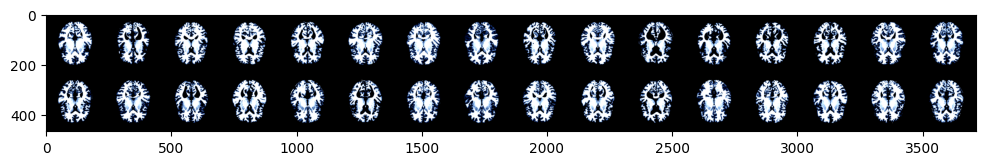

In [ ]:
for images, labels in datamodule_all.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

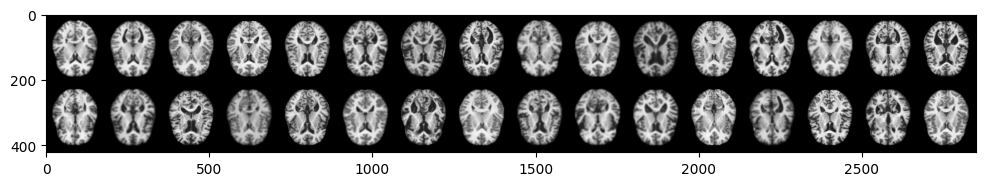

In [ ]:
for images, labels in datamodule_gaussian.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

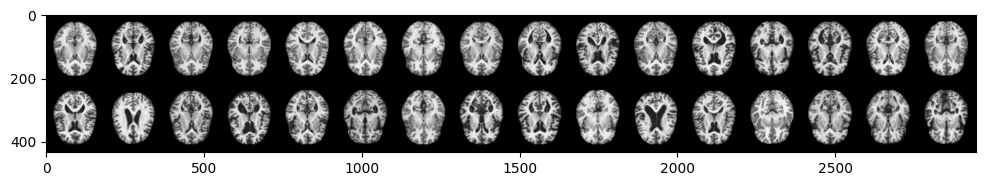

In [ ]:
for images, labels in datamodule_pad.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
#for images, labels in datamodule_erase.train_dataloader():
#    break
#im=make_grid(images,nrow=16)

#plt.figure(figsize=(12,12))
#plt.imshow(np.transpose(im.numpy(),(1,2,0)))

AttributeError: ignored

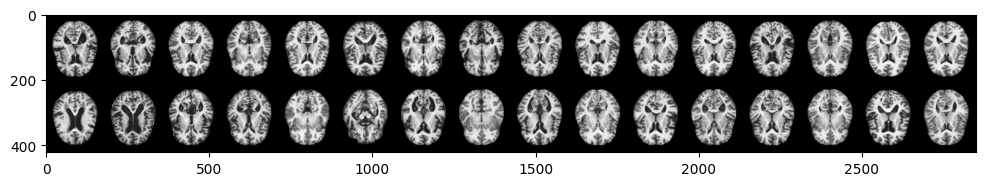

In [ ]:
for images, labels in datamodule_gray.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Definindo e treinando o modelo base: ResNet

In [21]:
print(len(class_names))

3


In [24]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

batch_size = 20
#weights = torch.Tensor([0.07,1,0.006,0.028]).to("cuda:0")

class MyModel(LightningModule):

    def __init__(self):
        num_classes = len(class_names)
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs,len(class_names))

        # TorchMetrics
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

        #self.all_labels = torch.empty((batch_size), device=torch.device('cuda'))
        #self.all_preds = torch.empty((batch_size), device=torch.device('cuda'))

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y) #weights)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.train_metrics(pred, y)
        self.log_dict(output)

        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)


        loss = F.cross_entropy(y_hat, y) #weights)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.val_metrics(pred, y)
        self.log_dict(output)


    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y) #weights)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        if (batch_idx == 0):
            self.all_labels = y.clone()
            self.all_preds = pred.clone()
        else:
            self.all_labels = torch.cat((self.all_labels, y))
            self.all_preds = torch.cat((self.all_preds, pred))

        output = self.test_metrics(pred, y)
        self.log_dict(output)


# Treinamento dos modelos

In [27]:

epochs = 75
model_base = MyModel()
trainer_base = pl.Trainer(max_epochs=epochs)
trainer_base.fit(model_base, datamodule_base)

model_rotate = MyModel()
trainer_rotate = pl.Trainer(max_epochs=epochs)
trainer_rotate.fit(model_rotate, datamodule_rotate)

model_hzflip = MyModel()
trainer_hzflip = pl.Trainer(max_epochs=epochs)
trainer_hzflip.fit(model_hzflip, datamodule_hzflip)

model_resize = MyModel()
trainer_resize = pl.Trainer(max_epochs=epochs)
trainer_resize.fit(model_resize, datamodule_resize)

model_crop = MyModel()
trainer_crop = pl.Trainer(max_epochs=epochs)
trainer_crop.fit(model_crop, datamodule_crop)

model_normalize = MyModel()
trainer_normalize = pl.Trainer(max_epochs=epochs)
trainer_normalize.fit(model_normalize, datamodule_normalize)

model_all = MyModel()
trainer_all = pl.Trainer(max_epochs=epochs)
trainer_all.fit(model_all, datamodule_all)

model_gaussian = MyModel()
trainer_gaussian = pl.Trainer(max_epochs=epochs)
trainer_gaussian.fit(model_gaussian, datamodule_gaussian)

model_pad = MyModel()
trainer_pad = pl.Trainer(max_epochs=epochs)
trainer_pad.fit(model_pad, datamodule_pad)

#model_erase = MyModel()
#trainer_erase = pl.Trainer(max_epochs=epochs)
#trainer_erase.fit(model_erase, datamodule_erase)

model_gray = MyModel()
trainer_gray = pl.Trainer(max_epochs=epochs)
trainer_gray.fit(model_pad, datamodule_gray)

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Teste dos modelos

In [28]:
print("Base Model")
datamodule_base.setup(stage='test')
test_loader_base = datamodule_base.test_dataloader()
metrics_base = trainer_base.test(dataloaders=test_loader_base)

print("Base Model + Rotation")
datamodule_rotate.setup(stage='test')
test_loader_rotate = datamodule_rotate.test_dataloader()
metrics_rotate = trainer_rotate.test(dataloaders=test_loader_rotate)

print("Base Model + Horizontal Flip")
datamodule_hzflip.setup(stage='test')
test_loader_hzflip = datamodule_hzflip.test_dataloader()
metrics_hzflip = trainer_hzflip.test(dataloaders=test_loader_hzflip)

print("Base Model + Resize")
datamodule_resize.setup(stage='test')
test_loader_resize = datamodule_resize.test_dataloader()
metrics_resize = trainer_resize.test(dataloaders=test_loader_resize)

print("Base Model + Crop")
datamodule_crop.setup(stage='test')
test_loader_crop = datamodule_crop.test_dataloader()
metrics_crop = trainer_crop.test(dataloaders=test_loader_crop)

print("Base Model + Normalize")
datamodule_normalize.setup(stage='test')
test_loader_normalize = datamodule_normalize.test_dataloader()
metrics_normalize = trainer_normalize.test(dataloaders=test_loader_normalize)

print("Base Model + All")
datamodule_all.setup(stage='test')
test_loader_all = datamodule_all.test_dataloader()
metrics_all = trainer_all.test(dataloaders=test_loader_all)

print("Base Model + Gaussian")
datamodule_gaussian.setup(stage='test')
test_loader_gaussian = datamodule_gaussian.test_dataloader()
metrics_gaussian = trainer_gaussian.test(dataloaders=test_loader_gaussian)

print("Base Model + Pad")
datamodule_pad.setup(stage='test')
test_loader_pad = datamodule_pad.test_dataloader()
metrics_pad = trainer_pad.test(dataloaders=test_loader_pad)

#print("Base Model + Erase")
#datamodule_erase.setup(stage='test')
#test_loader_erase = datamodule_erase.test_dataloader()
#metrics_erase = trainer_erase.test(dataloaders=test_loader_erase)

print("Base Model + Gray")
datamodule_gray.setup(stage='test')
test_loader_gray = datamodule_gray.test_dataloader()
metrics_gray = trainer_gray.test(dataloaders=test_loader_gray)

Base Model


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.5555555820465088     │
│ test_MulticlassPrecision  │    0.6481481194496155     │
│   test_MulticlassRecall   │    0.5555555820465088     │
└───────────────────────────┴───────────────────────────┘

Base Model + Rotation


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.5277777910232544     │
│ test_MulticlassPrecision  │    0.43518519401550293    │
│   test_MulticlassRecall   │    0.5277777910232544     │
└───────────────────────────┴───────────────────────────┘

Base Model + Horizontal Flip


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.5833333730697632     │
│ test_MulticlassPrecision  │    0.8666666150093079     │
│   test_MulticlassRecall   │    0.5833333730697632     │
└───────────────────────────┴───────────────────────────┘

Base Model + Resize


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.5833333730697632     │
│ test_MulticlassPrecision  │     0.523809552192688     │
│   test_MulticlassRecall   │    0.5833333730697632     │
└───────────────────────────┴───────────────────────────┘

Base Model + Crop


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │            0.5            │
│ test_MulticlassPrecision  │    0.5151515007019043     │
│   test_MulticlassRecall   │            0.5            │
└───────────────────────────┴───────────────────────────┘

Base Model + Normalize


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.4722222089767456     │
│ test_MulticlassPrecision  │    0.5079365372657776     │
│   test_MulticlassRecall   │    0.4722222089767456     │
└───────────────────────────┴───────────────────────────┘

Base Model + All


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.4166666567325592     │
│ test_MulticlassPrecision  │    0.5072463750839233     │
│   test_MulticlassRecall   │    0.4166666567325592     │
└───────────────────────────┴───────────────────────────┘

Base Model + Gaussian


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │            0.5            │
│ test_MulticlassPrecision  │    0.5151515007019043     │
│   test_MulticlassRecall   │            0.5            │
└───────────────────────────┴───────────────────────────┘

Base Model + Pad


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.5833333730697632     │
│ test_MulticlassPrecision  │    0.8666666150093079     │
│   test_MulticlassRecall   │    0.5833333730697632     │
└───────────────────────────┴───────────────────────────┘

Base Model + Gray


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.5138888955116272     │
│ test_MulticlassPrecision  │    0.6833333969116211     │
│   test_MulticlassRecall   │    0.5138888955116272     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Matrizes de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_matrix(title, model):

    ax = plt.subplot()
    cm = confusion_matrix(model.all_labels.cpu(), model.all_preds.cpu())

    sns.set_style("darkgrid")
    sns.set(rc={"figure.figsize":(20, 4)})
    colormap = sns.color_palette("Blues",12)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=colormap)

    # labels, title and ticks
    ax.set_xlabel('Predições:')
    ax.set_ylabel('Labels:')
    ax.set_title("Matriz de confusão - " + title);
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names, rotation=0)

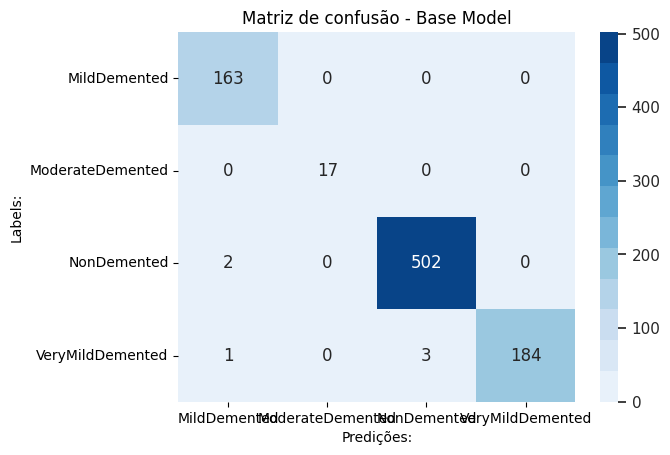

In [ ]:
plot_matrix("Base Model", model_base)

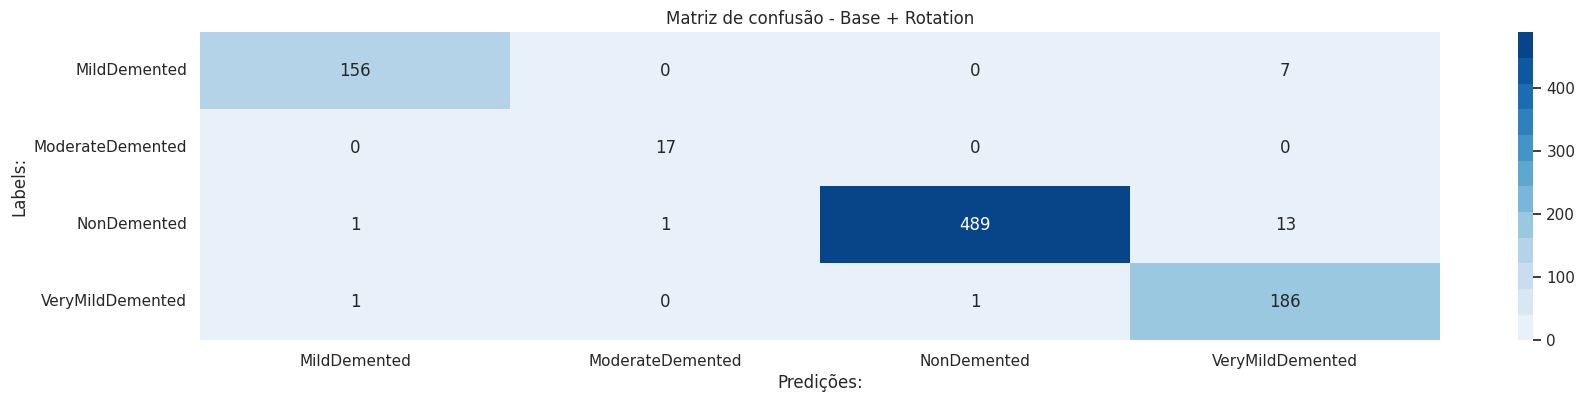

In [ ]:
plot_matrix("Base + Rotation", model_rotate)

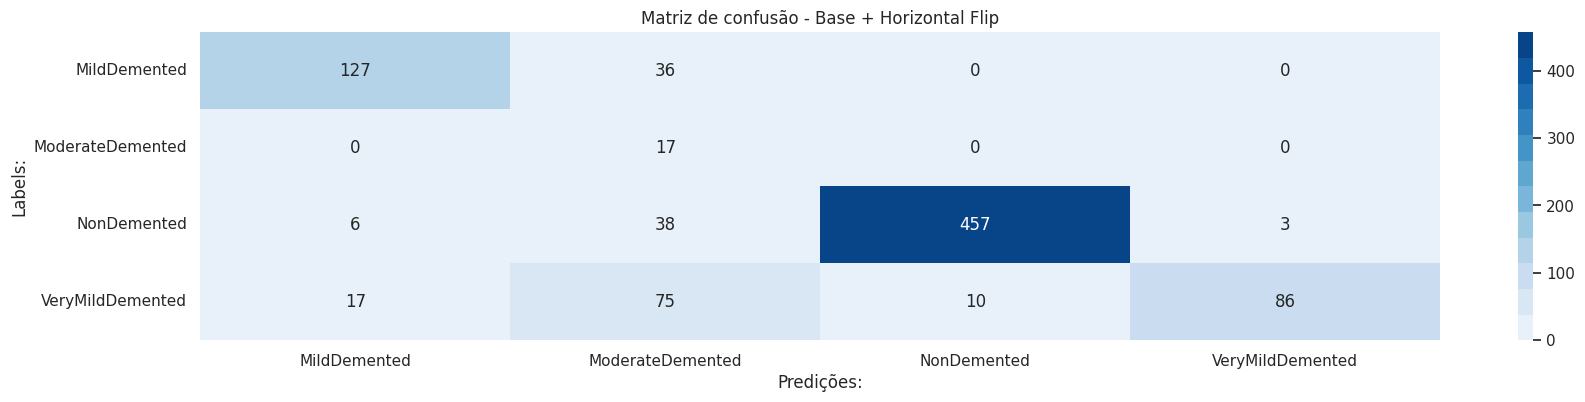

In [ ]:
plot_matrix("Base + Horizontal Flip", model_hzflip)

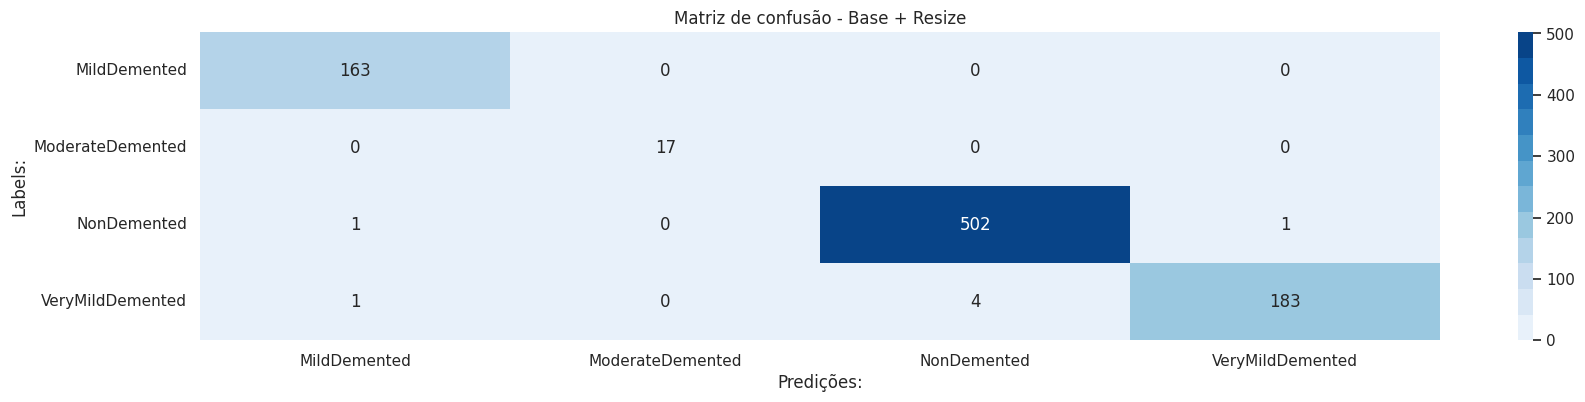

In [ ]:
plot_matrix("Base + Resize", model_resize)

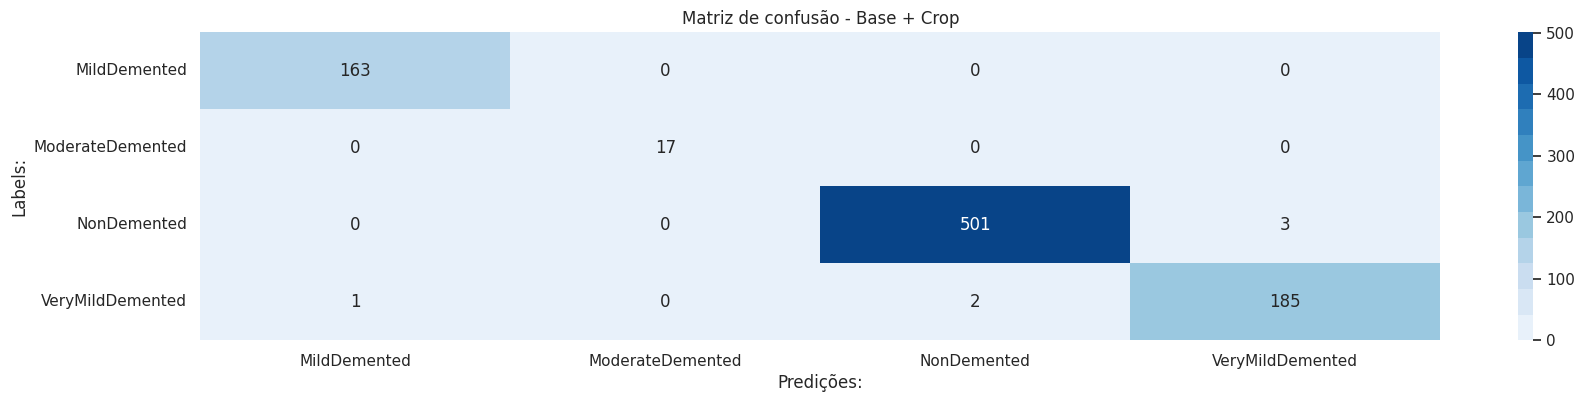

In [ ]:
plot_matrix("Base + Crop", model_crop)

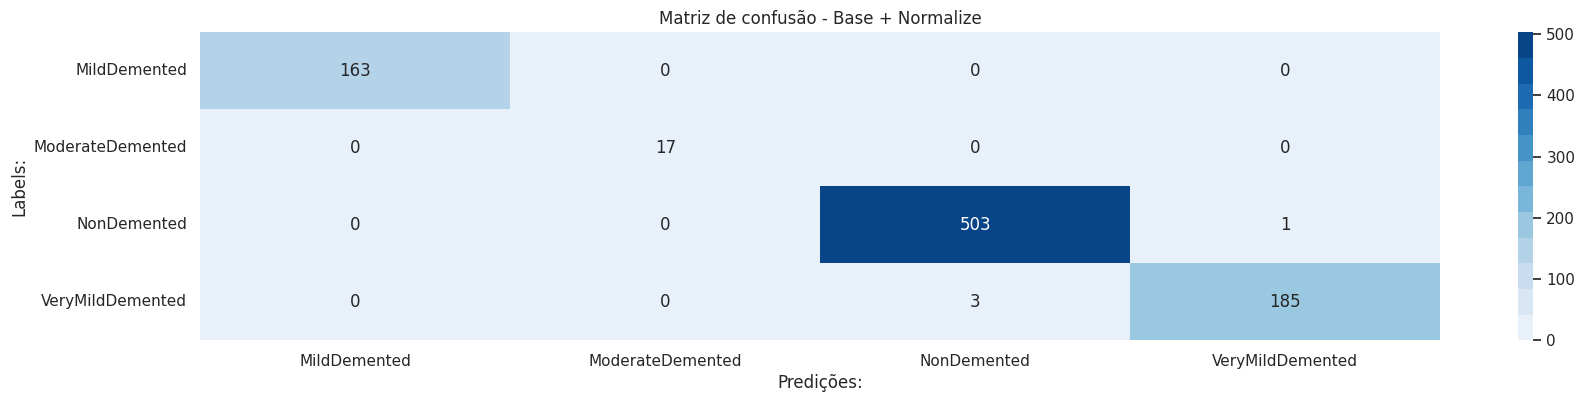

In [ ]:
plot_matrix("Base + Normalize", model_normalize)

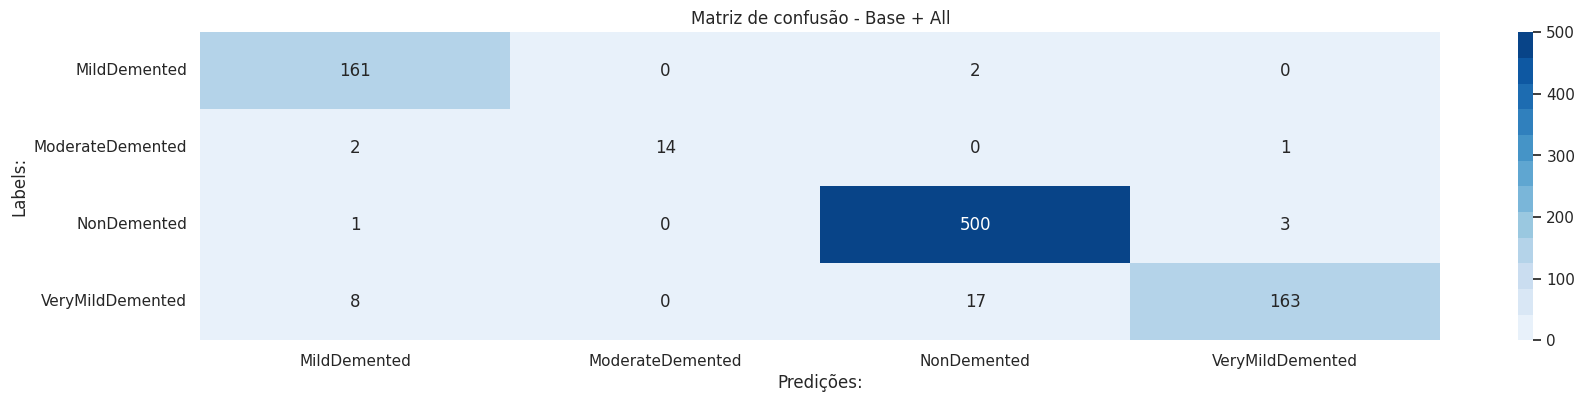

In [ ]:
plot_matrix("Base + All", model_all)